#

In [27]:
system_prompt = """
You are an advanced classifying AI. Your task is to classify the sentiment of a text. Sentiment can be either ‘positive’, ‘negative’, or ‘neutral’.
**Instructions**
  1. Examine each row in the table under the 'Text' column.
  2. For each row consisting of social media comments, classify the content into either ‘negative’, ‘neutral’, or ‘positive’.
  3. Fill the 'Classification' column for the corresponding 'Text' row with your answer. Your answer MUST be one of [‘negative’, ‘neutral’, ‘positive’], and it should be presented in lowercase.
**Formatting**
Return a markdown table with the columns "shortcode" and "Classification"
"""

#### From Documents to Markdown Tables

We use the `tabulate` python package to create markdown tables for as
many tables as we manage to send within the model’s context window.
Currently, the result_table token length (the mockup response) is
calculated using the length of `False`. Replace the value if you expect
longer classifications in this line:

``` python
current_result_table = tabulate(batched_data + [(row[meta], False)], headers=[meta, "Classification"], tablefmt="pipe")
```

In [28]:
from tabulate import tabulate
from datetime import datetime
from gpt_cost_estimator import num_tokens_from_messages

def batch_rows_for_tables(df, system_prompt, column, meta, model="gpt-3.5-turbo-0613", **kwargs):
    max_rows = kwargs.get("max_rows", 999)
    if model == "gpt-4-0613":
      max_tokens = 8192

    if model == "gpt-4-1106-preview":
      max_tokens = 128000 # This model has not been tested with the multidocument approach. It is only capable of 4096 tokens output, therefore we might run into trouble

    if model == "gpt-3.5-turbo-0613":
      max_tokens = 4096

    """Batch rows from the dataframe to fit within token limits and return as a list of markdown tables."""
    tables = []

    df[column] = df[column].astype(str)

    pbar = tqdm(total=len(df))


    while not df.empty:
        current_tokens = 0
        batched_data = []
        batched_results = []

        i = 0
        for index, row in df.iterrows():
            # Remove newline characters from the specific column
            cleaned_data = row[column].replace('\n', ' ')

            # Construct the table for the current batch
            current_table = tabulate(batched_data + [(row[meta], cleaned_data)], headers=[meta, "Text"], tablefmt="pipe")
            current_result_table = tabulate(batched_data + [(row[meta], False)], headers=[meta, "Classification"], tablefmt="pipe")

            message = [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": current_table},
                {"role": "assistant", "content": current_result_table}
                ]

            tokens_needed = num_tokens_from_messages(message, model=model)

            if tokens_needed <= max_tokens and i < max_rows:
                current_tokens = tokens_needed
                batched_data.append((row[meta], cleaned_data))
                batched_results.append((row[meta], False))
                df.drop(index, inplace=True)
                i += 1
            else:
                # Stop when you've reached close to the max token count
                pbar.update(len(batched_data))
                break

        # Convert batched rows to a markdown table and store in tables list
        markdown_table = tabulate(batched_data, headers=[meta, "Text"], tablefmt="pipe")
        tables.append(markdown_table)

    pbar.close()

    return tables

The next command uses the above function to generate all necessary
markdown tables. The `column` parameter of `batch_rows_for_tables`
expects the name of the text column, the `meta` parameter expects the
name of the identifier column. Additionally, we pass the dataframe,
`system_prompt`, and `MODEL` to the function. Fill in the `TEXT_COLUMN`,
`IDENTIFIER`, `MODEL`, and `MAX_ROWS` variables as needed. See the
comments above each variable for more information.

In [40]:
#@markdown What's the column name of the text column?
TEXT_COLUMN = 'Text' # @param {type: "string"}
#@markdown What's the column name of the text column?
IDENTIFIER = 'shortcode' # @param {type: "string"}
#@markdown Which model do you want to use?
MODEL = "gpt-4-0613" # @param ["gpt-3.5-turbo-0613", "gpt-4-1106-preview", "gpt-4-0613"] {allow-input: true}
#@markdown Is there a maximum length of rows? (**Set a very high number, like 999, to disable this feature**)
MAX_ROWS = 999 # @param {type: "number", min:0}

# Create a copy of your df. This is important! The batching process removes processed rows from the df.
df_batch_copy = df.copy()

# Batching the tables, takes a few seconds (~1 Minute)
tables = batch_rows_for_tables(df_batch_copy, system_prompt, TEXT_COLUMN, IDENTIFIER, MODEL, max_rows=MAX_ROWS)

Let’s inspect the table. This is one of many tables that will be sent to
the model. (I set the `MAX_ROWS` to 5 to keep the example short. When
working with this approach I usually use `MAX_ROWS=999`.)

In [41]:
print(tables[0])

| shortcode   | Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

We can also inspect them using Markdown formatting in the notebooks:

In [42]:
from IPython.display import Markdown, display

display(Markdown(tables[0]))

#### Run the Multidocument Request

he following code snippet uses my
[gpt-cost-estimator](https://pypi.org/project/gpt-cost-estimator/)
package to simulate API requests and calculate a cost estimate. Please
run the estimation whne possible to asses the price-tag before sending
requests to OpenAI!

Fill in the `MOCK`, `RESET_COST`, `SAMPLE_SIZE`, `CLASS_NAME`, and
`FILE_NAME` variables as needed (see comments above each variable.)

In [37]:
from tqdm.auto import tqdm
import json
import ast
from datetime import datetime
from io import StringIO

#@title Run the Multidocument Request
#@markdown T
#@markdown Do you want to mock the OpenAI request (dry run) to calculate the estimated price?
MOCK = False # @param {type: "boolean"}
#@markdown Do you want to reset the cost estimation when running the query?
RESET_COST = True # @param {type: "boolean"}

#@markdown How many **tables** do you want to send? Enter $0$ for all.
SAMPLE_SIZE = 1 # @param {type: "number", min: 0}

#@markdown Filename for the **new** table that only contains sentiments.
FILE_NAME = '/content/drive/MyDrive/2023-12-08-Posts-LTW-Sentiment' # @param {type: "string"}

#@markdown Name for the classification column
CLASS_NAME = 'Sentiment' # @param {type: "string"}


def safe_literal_eval(value):
    if isinstance(value, (str, bytes)):
        try:
            return ast.literal_eval(value)
        except ValueError:
            return value  # or handle the error in another way if you want
    return value

def parse_response(response):
    # Determine if the response is a list or markdown table
    if ':' in response.split('\n')[0]:
        # List
        lines = [line.strip() for line in response.strip().split('\n')]
        data = [(int(line.split(': ')[0]), line.split(': ')[1]) for line in lines]
        # Convert the parsed data into a DataFrame
        result_df = pd.DataFrame(data, columns=['uuid', 'Positioning'])
    else:
        # Markdown Table
        csv_data = '\n'.join([','.join(line.split('|')[1:-1]) for line in response.split('\n') if line.strip() and not line.startswith('|:')])
        result_df = pd.read_csv(StringIO(csv_data.strip()), sep=",", skipinitialspace=True)


    # Striping Whitespaces
    result_df.columns = [col.strip() for col in result_df.columns]
    if 'Classification' in result_df.columns:
        # Renaming the column to fit the rest of the project.
        result_df = result_df.rename(columns={"Classification": CLASS_NAME})

    result_df = result_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    return result_df


try:
    # Attempt to read the CSV file into a DataFrame
    new_df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    # If the file is not found, create an empty DataFrame with the specified columns
    new_df = pd.DataFrame(columns=[IDENTIFIER, CLASS_NAME])

# Reset Estimates
CostEstimator.reset()
print("Reset Cost Estimation")

if 0 < SAMPLE_SIZE <= len(tables):
    filtered_tables = tables[:SAMPLE_SIZE]
else:
    filtered_tables = tables

for table in tqdm(filtered_tables):
    result = run_request(system_prompt, table, MODEL, MOCK)
    if result and not MOCK:
      # Parsing the data
      result_df = parse_response(result.choices[0].message.content)

      # Append it to master_df
      new_df = pd.concat([new_df, result_df], ignore_index=True)

      # Save Progress
      new_df.to_csv(FILE_NAME, index=False)

print()

if not MOCK:
  print(f"Saved {FILE_NAME}.")

  new_df = new_df.dropna(subset=[IDENTIFIER])
  new_df[CLASS_NAME] = new_df[CLASS_NAME].apply(safe_literal_eval)
  uuid_to_classification = new_df.set_index(IDENTIFIER)[CLASS_NAME].to_dict()
  mask = df[IDENTIFIER].isin(uuid_to_classification.keys())
  df.loc[mask, CLASS_NAME] = df.loc[mask, IDENTIFIER].replace(uuid_to_classification)

print()

Reset Cost Estimation

Cost: $0.1408 | Total: $0.1408
Saved /content/drive/MyDrive/2023-12-08-Posts-LTW-Sentiment.


In [38]:
new_df.head()

The code above expects the GPT-API to return results in a markdown
formatted table (see above). We keep appending the API responses to a
`new_df` where we temporarily store the classifications. For each loop
(i.e. each time received a classification), we store the results on
Google Drive as a backup, since each result has a price tag. In case of
error we can resume the operation later without the need to start all
over again. The code above does not provide the necessary logic for
that, but you should be able to quickly add it.

Once the loop finished, we use the `shortcode` column from the API
response and join the classification data with `df`:

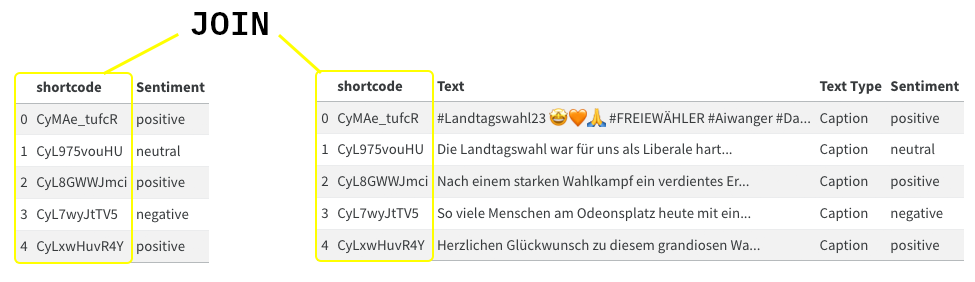

And finally our `df` looks as follows. As outlined at the start of the
[text exploration](../processing/exploration.qmd) chapter, we want to
fill one dataframe piece by piece with more and more classifications.

In [44]:
df[mask][['shortcode', 'Text', 'Text Type', 'Sentiment']].head()